# How does adaptive sampling influence post-trial inference?

The idea of this notebook is to explore the behaviour of post-inference techniques, especially (naive) frequentist and bayesian approaches to adaptive sampling.
We therefore generate a simple example and test out which biases occur.

Please note that the example and the policies are not necessarily **good**, but are designed to show how the biases occur.

## Assumptions:
- Generated outcome may only depend on current context and treatment. (no crossover effect)

## Running example

Let's consider we want to compare to treatments Treatment_1 and Treatment_2.
For simplicity, we stay in the discrete case, and assume Treatment_1 has an average treatment effect of 10, and Treatment_2 has an average treatment effect of 20 both with a variance of 0.1.
We first compare a frequentist analysis in an AB design. By simulating the trial 10 times and looking at the estimates

In [286]:
import numpy as np
import pandas as pd
import seaborn as sns

In [287]:
# Set some constants
n_trials = 1000
n_observations = 1000

In [288]:

df = pd.DataFrame(columns=["outcome", "treatment", "trial"])
# Simple AB treatment schedule
df["treatment"] = [1,2] * n_observations * int(n_trials / 2)
df["trial"] = df.index // n_observations
df["outcome"] = (
    (df["treatment"] == 1) * np.random.normal(1,1, len(df)) +
    (df["treatment"] == 2) * np.random.normal(2,1, len(df))
)
df_fixed_schedule = df

## "Play the Winner"-Bias
Let's assume a simple policy: we test both treatments one time, and then only choose the best one (explore then commit with n=1).
This will induce a "play-the-winner"-bias. 

See also:
Bowden, J., & Trippa, L. (2017). Unbiased estimation for response adaptive clinical trials. Statistical Methods in Medical Research, 26(5), 2376–2388. https://doi.org/10.1177/0962280215597716

In [289]:
df = pd.DataFrame(columns=["outcome", "treatment", "trial"])
# Simple AB treatment schedule
df["treatment"] = [1,2] * n_observations * int(n_trials / 2)
df["outcome"] = (
    (df["treatment"] == 1) * np.random.normal(1,1, len(df)) +
    (df["treatment"] == 2) * np.random.normal(2,1, len(df))
)
df["trial"] = df.index // n_observations

# All rows are adaptive except the first two of every trial
df["adaptive"] = df.index % n_observations > 1
df_pivoted = df.loc[~df["adaptive"]].pivot(index="trial",values="outcome", columns="treatment")
df_pivoted["better_treatment"] = np.where(df_pivoted[1] > df_pivoted[2], 1, 2)

# Add the better_treatment to the original dataset
df = df.join(df_pivoted,on="trial")

# Set the adaptive treatments to the better treatment
df["treatment"] = np.where(df["adaptive"], df["better_treatment"], df["treatment"])

# Update the observations
df["outcome"] = np.where(df["adaptive"],
    (df["treatment"] == 1) * np.random.normal(1,1, len(df)) +
    (df["treatment"] == 2) * np.random.normal(2,1, len(df)),
                         df["outcome"]
)
df_play_the_winner = df

<Axes: xlabel='Count', ylabel='outcome'>

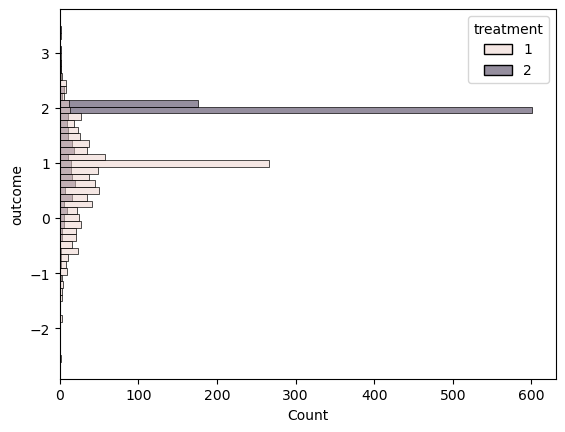

In [290]:
sns.histplot(data=df_play_the_winner.groupby(["trial","treatment"]).mean(), y="outcome", hue="treatment", bins=50)

<Axes: xlabel='Count', ylabel='outcome'>

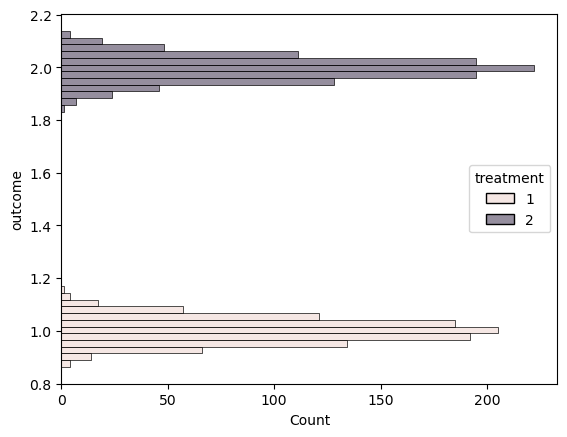

In [291]:
sns.histplot(data=df_fixed_schedule.groupby(["trial","treatment"]).mean(), y="outcome", hue="treatment", bins=50)

We observe a very small bias that makes the estimated treatment effect smaller than it is.

Also, we observe that we see much more variance in treatment 1 than in treatment 2, simply because we have a lot more obervation points for treatment 2.

In [294]:
print(df_fixed_schedule.groupby("treatment").mean()["outcome"])
print(df_play_the_winner.groupby("treatment").mean()["outcome"])
print(f'Measured bias for treatment 2: {(df_fixed_schedule.groupby("treatment").mean()["outcome"][2] - df_play_the_winner.groupby("treatment").mean()["outcome"][2]):.10f}')

treatment
1    1.001884
2    1.996202
Name: outcome, dtype: float64
treatment
1    1.001797
2    1.998533
Name: outcome, dtype: float64
Measured bias for treatment 2: -0.0023313376


### What do I need to do?
Probably nothing, since really small.
Best practice would probably be to test this out in a simulation study.
The estimate for Treatment 2 under the adaptive regime might be biased, but still better than under fixed schedule due to more sample points for the better treatment.

## Contextual Bias
Another potential bias we can get is contextual bias. If our policy introduces a dependency between contextual variable and treatment, and we do not control for it, we might take it as a treatment effect. Note that this is not only a problem with adaptive schedules, since it can also happen with fixed schedules.
However, it might be more likely with contextual bandit algorithms.
Let's consider a binary contextual variable c that can have a positive additive effect on outcome, and by chance is only 1 when we give treatment 2.

In [295]:
df = pd.DataFrame(columns=["outcome", "treatment", "trial"])
# Simple AB treatment schedule
df["treatment"] = [1,2] * n_observations * int(n_trials / 2)
df["trial"] = df.index // n_observations
df["context"] = df["treatment"] - 1
df["outcome"] = (
    (df["treatment"] == 1) * np.random.normal(1,1, len(df)) +
    (df["treatment"] == 2) * np.random.normal(2,1, len(df)) +
    df["context"]
)
df_fixed_schedule = df
df_play_the_winner = df

<Axes: xlabel='Count', ylabel='outcome'>

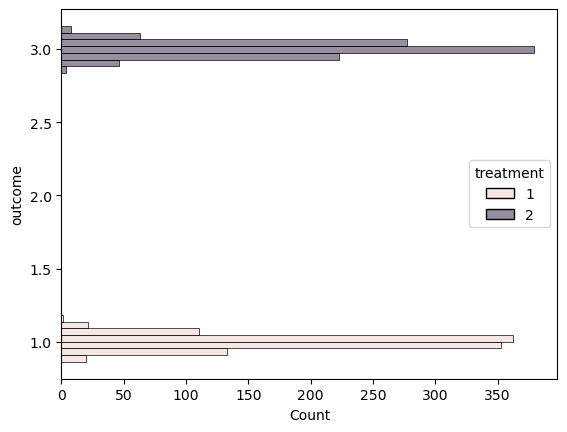

In [296]:
sns.histplot(data=df_play_the_winner.groupby(["trial","treatment"]).mean(), y="outcome", hue="treatment", bins=50)

A naive mean will overestimate the treatment effect to 3.

### What do I need to do?
Check if covariates are independent of treatment schedule, or control for non-independence.
Here, we have a strong dependence from time t <--> treatment. Adaptive policies might introduce more of these dependencies.
A special case of this might also be a baseline shift in the data. While a baseline shift violates our assumptions, modeling the baseline as a covariate might make the assumption valid again, but induce covariate bias.